# Final exam
## Robust control via Sliding mode control
В данной работе сравним 2 типа управления применительно к системе, в которой есть структурные и неструктурные неопределенности, в качестве системы выступает 6-DoF манипулятор. Введем в модель дополнительное Кулоновское трение и вязкое трение (неструктурные неопределенности), а так же добавим дополнительную массу к рабочему органу (структурная неопределнность)

## Inverse Dynamics control

### Theory

Уравнение манипулятора, с которым мы будем работать:

\begin{equation}
\mathbf{M}(q)\ddot{q} + \mathbf{C}(q,\dot{q})\dot{q} + \mathbf{g}(q) + \mathbf{D}\dot{q} + \mathbf{F_c}(\dot{q}) = \tau
\end{equation}

где $\mathbf{M}(q)$ — матрица инерции (с неопределенностью),

$\mathbf{C}(q,\dot{q})$ — матрица сил инерции и Кориолисовых сил (с неопределенностью),

$\mathbf{g}(q)$ — вектор сил тяжести (с неопределенностью),

$\mathbf{D}$ — матрица вязкого трения (не известна),

$\mathbf{F_c}(\dot{q})$ — вектор сил Кулоновского трения (не известен),

$\tau$ — вектор управляющих усилий.


Создадим inverse dynamics controller и проверим, как он будет работать с системой с неопределнностями. Предполагаемо, метод будет рабоать не очень хорошо, исходя из того, что не учитыват неопределенности, доказать это можно, подставив управление в наше уравнение и получив вместо: $\ddot{\tilde{q}} + k_d\dot{\tilde{q}} + k_p\tilde{q} = 0$ дифференциальное уравнение с нескомпенсированными $\mathbf{M}$, $\mathbf{C}$, $\mathbf{g}$, $\mathbf{D}$, и $\mathbf{F_c}$, так как реальное их значение нам неизвестно.

\begin{equation}
\begin{cases}
\tau = \hat{\mathbf{M}}(q)a_q + \hat{\mathbf{C}}(q,\dot{q})\dot{q} + \hat{\mathbf{g}}(q) \\
a_q = \ddot{q}_d + k_p(q_{des} - q) + k_d(\dot{q}_{des}-\dot{q})
\end{cases}
\end{equation}

In [1]:
import numpy as np
from simulator import Simulator
from pathlib import Path
import os
from typing import Dict
import matplotlib.pyplot as plt
import pinocchio as pin
from IPython.display import Video

In [2]:
current_dir = os.getcwd()
xml_path = os.path.join(current_dir, "robots/universal_robots_ur5e/ur5e.xml")
model = pin.buildModelFromMJCF(xml_path)
data = model.createData()

In [3]:
# Desired 
q_des = np.array([-1.4, -1.2, 1., -0.2, 0.2, 0.5])

### Controller

In [4]:
def joint_controller_ID(q: np.ndarray, dq: np.ndarray, t: float) -> np.ndarray:
    """Joint space PD controller.
    
    Args:
        q: Current joint positions [rad]
        dq: Current joint velocities [rad/s]
        t: Current simulation time [s]
        
    Returns:
        tau: Joint torques command [Nm]
    """
    # Control gains tuned for UR5e
    kp = np.array([100, 100, 100, 100, 100, 100])
    kd = np.array([20, 20, 20, 20, 20, 20])
    
    # Target joint configuration
    q0 = q_des
    
    # Dynamics computation
    pin.computeAllTerms(model, data, q, dq)
    M = data.M
    nle = data.nle

    # PD controller
    a_q = kp*(q0 - q) + kd*(-dq)

    # Inverse dynamics
    tau = M @ a_q + nle

    return tau

### Simulation

In [5]:
# Create logging directories
Path("logs/videos").mkdir(parents=True, exist_ok=True)

# Initialize simulator
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=False,  # Using joint space control
    show_viewer=False,
    record_video=True,
    video_path="logs/videos/06_inverse_dynamics.mp4",
    fps=30,
    width=1920,
    height=1080
)

# Set joint damping (example values, adjust as needed)
damping = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm/rad/s
sim.set_joint_damping(damping)

# Set joint friction (example values, adjust as needed)
friction = np.array([1.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm
sim.set_joint_friction(friction)

# Get original properties
ee_name = "end_effector"

original_props = sim.get_body_properties(ee_name)
print(f"\nOriginal end-effector properties:")
print(f"Mass: {original_props['mass']:.3f} kg")
print(f"Inertia:\n{original_props['inertia']}")

# Add the end-effector mass and inertia
sim.modify_body_properties(ee_name, mass=3)
# Print modified properties
props = sim.get_body_properties(ee_name)
print(f"\nModified end-effector properties:")
print(f"Mass: {props['mass']:.3f} kg")
print(f"Inertia:\n{props['inertia']}")

# Set controller and run simulation
sim.set_controller(joint_controller_ID)
sim.run(time_limit=10.0)

# Process and save results
times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Original end-effector properties:
Mass: 0.010 kg
Inertia:
[0.0001 0.0001 0.0001]

Modified end-effector properties:
Mass: 3.000 kg
Inertia:
[0.0001 0.0001 0.0001]
Saving video to logs/videos/06_inverse_dynamics.mp4...


### Video

In [6]:
Video(os.path.join(current_dir, "logs/videos/06_inverse_dynamics.mp4"))

### Plots

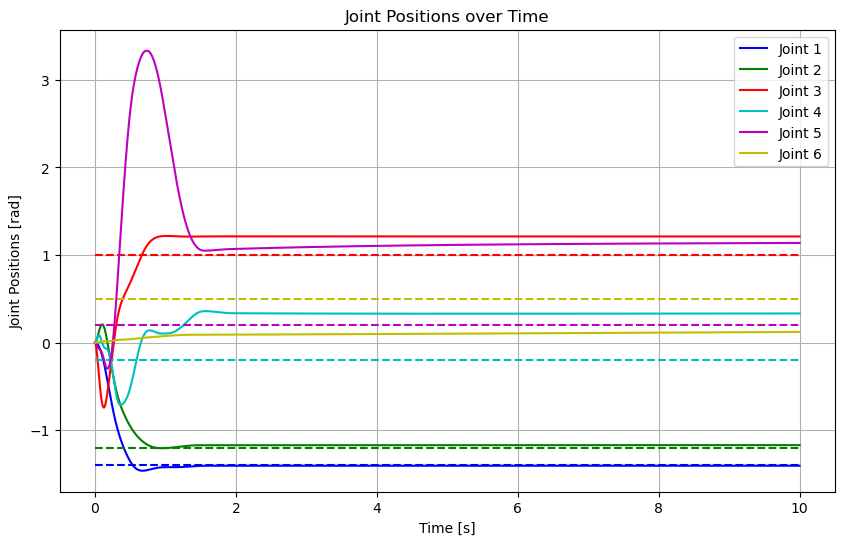

In [7]:
# Joint positions plot
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], colors[i], label=f'Joint {i+1}')
    plt.hlines(q_des[i], 0, times[-1], colors[i], '--')  
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_positions.png')
plt.show()

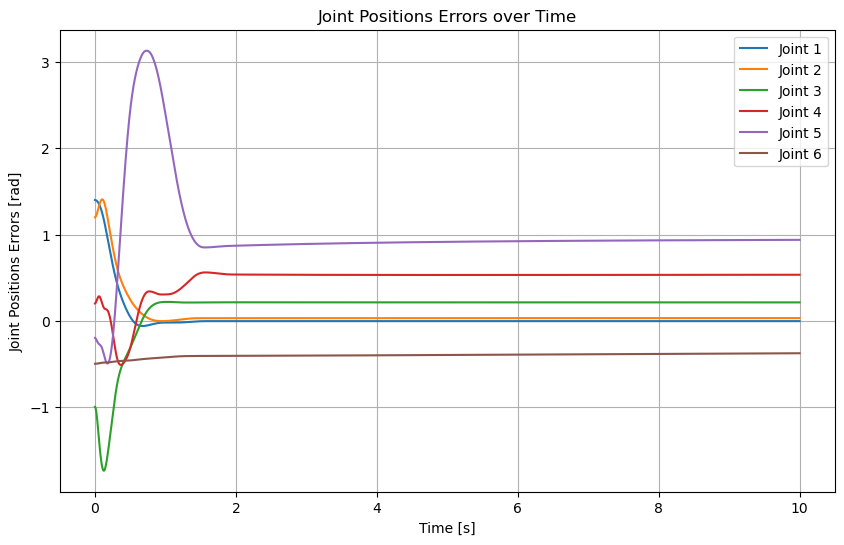

In [8]:
# Joint errors plot
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    pos_error = np.array([q_des[i] for j in range(positions.shape[0])])
    plt.plot(times, positions[:, i] - pos_error, label=f'Joint {i+1}') 
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions Errors [rad]')
plt.title('Joint Positions Errors over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_errors.png')
plt.show()

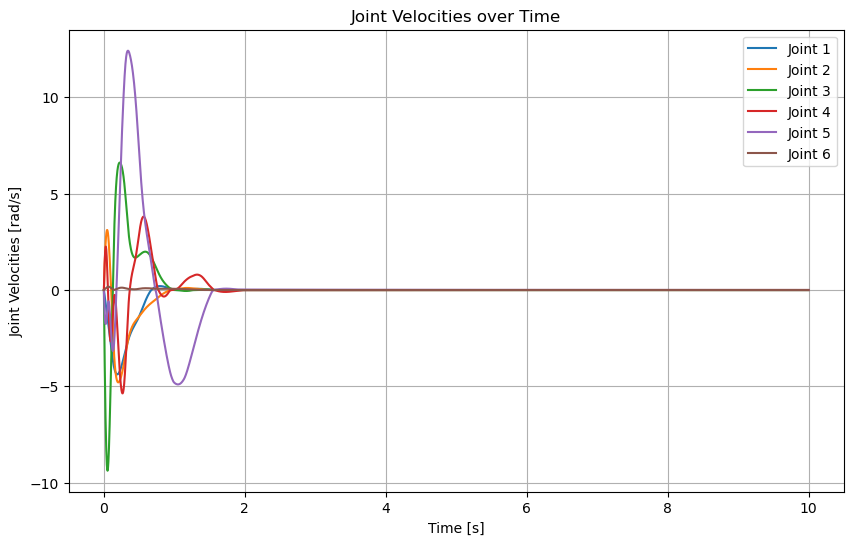

In [9]:
# Joint velocities plot
plt.figure(figsize=(10, 6))
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_velocities.png')
plt.show()

## Robust control

Как видно inverse dynamics controller плохо отрабатывает позицию, что неудивительно, ведь этот метод полностью компенсирует влияние всех внешних сил, однако, если некоторые из них не определены полностью или вовсе не известны, то метод не сможет их компенсировать. В этом случае необходимы методы, которые смогут работать с неопределенностями системы. Такие как robust control.

Реализуем robust controller с помощью метода скользящих поверхностей
 
### Theory

Вернемся к нашему уравнению манипулятора

\begin{equation}
\mathbf{M}(q)\ddot{q} + \mathbf{C}(q,\dot{q})\dot{q} + \mathbf{g}(q) + \mathbf{D}\dot{q} + \mathbf{F_c}(\dot{q}) = \tau
\end{equation}

Уравнение скользящей поверхности:

\begin{equation}
\mathbf{s} = (\frac{d}{dt} + \lambda)^{n-1}\tilde{q}
\end{equation}

Так как порялок системы $n=2$, то:
\begin{equation}
\mathbf{s} = \dot{\tilde{q}} + \lambda\tilde{q}
\end{equation}

Из этого уравнения видно, что как только $s \rightarrow 0$, то получается дифференциальное уравнение $\dot{\tilde{q}} + \lambda\tilde{q} = 0$, которое имеет решение, в котором $\tilde{q} \rightarrow 0$, то есть $q \rightarrow q_{des}$, что и необходимо.

Для того, чтобы добиться этого, опираясь на теорию устойчивости Ляпунова, составим функцию Ляпунова, такую, чтобы она была положительно определенной, а ее производная отрицательно определенной функцией. Пусть:
\begin{equation}
V = 0.5\mathbf{s}^2
\end{equation}

Тогда:
\begin{equation}
\dot{V} = \mathbf{s}^T\dot{\mathbf{s}} = \mathbf{s}(\ddot{\tilde{q}} + \lambda\dot{\tilde{q}})
\end{equation}

Для условия отрицательной определенности достаточно $\dot{V} < 0$, однако, что если составить неравенство не относительно 0, а относительно какого-то отрицательного числа:

\begin{equation}
\dot{V} = \mathbf{s}^T\dot{\mathbf{s}} \le -\eta|\mathbf{s}|
\end{equation}

Пусть $\mathbf{s} > 0$, тогда (если $\mathbf{s} < 0$ то неравенство разрешится так же):

\begin{equation}
\mathbf{s}^T\dot{\mathbf{s}} \le -\eta\mathbf{s} \\
\end{equation}

\begin{equation}
\dot{\mathbf{s}} \le -\eta
\end{equation}

Представим производную в следующем виде:

\begin{equation}
\dot{\mathbf{s}} = \frac{\mathbf{s}(t_f) - \mathbf{s}(t_s)}{t_f - t_s} 
\end{equation}

\begin{equation}
\frac{\mathbf{s}(t_f) - \mathbf{s}(t_s)}{t_f - t_s} \le -\eta
\end{equation}

В итоге получаем:

\begin{equation}
\begin{cases}
\frac{\mathbf{s}(t_f) - \mathbf{s}(t_s)}{t_f - t_s} \le -\eta\\
\mathbf{s}(t_f) = 0\\
t_s = 0
\end{cases}
\end{equation}

Тогда:

\begin{equation}
t_f \le \frac{\mathbf{s}(0)}{\eta}
\end{equation}

То есть, введя такое условие на $\dot{\mathbf{V}}$ получаем сходимость за определенное время. Поэтому составим следующее неравенство:
\begin{equation}
\dot{\mathbf{V}} = \mathbf{s}^T(\ddot{\tilde{q}} + \lambda\dot{\tilde{q}}) \le -\eta|\mathbf{s}|
\end{equation}

При том, что $\ddot{\tilde{q}} = \ddot{q}_{des} - \ddot{q}$. Выразим $\ddot{q}$ из нашего уравнения манипулятора:
\begin{equation}
\ddot{q} = \mathbf{M}^{-1}(q)(\tau - \mathbf{C}(q,\dot{q})\dot{q} - \mathbf{g}(q) - \mathbf{D}\dot{q} - \mathbf{F_c}(\dot{q}))
\end{equation}

Подставляя $\ddot{q}$ в неравенство:
\begin{equation}
\dot{\mathbf{V}} = \mathbf{s}^T(- \mathbf{M}^{-1}(q)(\tau - \mathbf{C}(q,\dot{q})\dot{q} - \mathbf{g}(q) - \mathbf{D}\dot{q} - \mathbf{F_c}(\dot{q})) + \ddot{q}_{des} + \lambda\dot{\tilde{q}}) \le -\eta|\mathbf{s}|
\end{equation}

Теперь перед нами стоит задача найти $\tau$ такое, чтобы $\dot{\mathbf{V}} \le -\eta|\mathbf{s}|$, но так как мы ничего не знаем о $\mathbf{D}$ и $\mathbf{F_c}(\dot{q})$ то и в управлении учесть их не можем, а истинных значений $\mathbf{M}(q)$, $\mathbf{C}(q,\dot{q})$ и $\mathbf{g}(q)$ мы не знаем, а знаем их лишь оценку: $\hat{\mathbf{M}}(q)$, $\hat{\mathbf{C}}(q,\dot{q})$ и $\hat{\mathbf{g}}(q)$

Положим $\tau$ следующим образом:
\begin{equation}
\tau = \hat{u} + u_s
\end{equation}

, где

\begin{equation}
\hat{u} = \hat{\mathbf{M}}(q)(\ddot{q}_{des} + \lambda\dot{\tilde{q}} + \hat{\mathbf{M}}^{-1}(q)\hat{\mathbf{C}}(q,\dot{q})\dot{q} + \mathbf{M}^{-1}(q)\hat{\mathbf{g}}(q))
\end{equation}

\begin{equation}
\hat{u} = \hat{\mathbf{M}}(q)(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) + \hat{\mathbf{C}}(q,\dot{q})\dot{q} + \hat{\mathbf{g}}(q)
\end{equation}

$\hat{u}$ компенсирует влияние матриц $\mathbf{M}(q)$, $\mathbf{C}(q,\dot{q})$ и $\mathbf{g}(q)$, хоть и не полностью, но это все, что у нас есть, остальную часть управления мы оставим на $u_s$, тогда необходимо выяснить, каким должен быть $u_s$

\begin{equation}
\dot{\mathbf{V}} = \mathbf{s}^T(- \mathbf{M}^{-1}(q)(\hat{\mathbf{M}}(q)(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) + \hat{\mathbf{C}}(q,\dot{q})\dot{q} + \hat{\mathbf{g}}(q) + u_s - \mathbf{C}(q,\dot{q})\dot{q} - \mathbf{g}(q) - \mathbf{D}\dot{q} - \mathbf{F_c}(\dot{q})) + \ddot{q}_{des} + \lambda\dot{\tilde{q}}) \le -\eta|\mathbf{s}|
\end{equation}

\begin{equation}
\dot{\mathbf{V}} = \mathbf{s}^T(- \mathbf{M}^{-1}(q)(\hat{\mathbf{M}}(q)(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) + \tilde{\mathbf{C}}(q,\dot{q})\dot{q} + \tilde{\mathbf{g}}(q) + u_s - \mathbf{D}\dot{q} - \mathbf{F_c}(\dot{q})) + \ddot{q}_{des} + \lambda\dot{\tilde{q}}) \le -\eta|\mathbf{s}|
\end{equation}

\begin{equation}
\dot{\mathbf{V}} = \mathbf{s}^T(-\mathbf{M}^{-1}(q)u_s + (\mathbf{I} - \mathbf{M}^{-1}(q)\hat{\mathbf{M}}(q))(\ddot{q}_{des} + \lambda\dot{\tilde{q}})- \mathbf{M}^{-1}(q)\tilde{\mathbf{C}}(q,\dot{q})\dot{q} - \mathbf{M}^{-1}(q)\tilde{\mathbf{g}}(q) + \mathbf{M}^{-1}(q)\mathbf{D}\dot{q} + \mathbf{M}^{-1}(q)\mathbf{F_c}(\dot{q})) \le -\eta|\mathbf{s}|
\end{equation}

Опять же, если мы положим $\mathbf{s} > 0$, то получим:
\begin{equation}
-\mathbf{M}^{-1}(q)u_s + (\mathbf{I} - \mathbf{M}^{-1}(q)\hat{\mathbf{M}}(q))(\ddot{q}_{des} + \lambda\dot{\tilde{q}})- \mathbf{M}^{-1}(q)\tilde{\mathbf{C}}(q,\dot{q})\dot{q} - \mathbf{M}^{-1}(q)\tilde{\mathbf{g}}(q) + \mathbf{M}^{-1}(q)\mathbf{D}\dot{q} + \mathbf{M}^{-1}(q)\mathbf{F_c}(\dot{q}) \le -\eta
\end{equation}

\begin{equation}
-u_s + (\mathbf{M}(q) - \hat{\mathbf{M}}(q))(\ddot{q}_{des} + \lambda\dot{\tilde{q}})- \tilde{\mathbf{C}}(q,\dot{q})\dot{q} - \tilde{\mathbf{g}}(q) + \mathbf{D}\dot{q} + \mathbf{F_c}(\dot{q}) \le -\mathbf{M}(q)\eta
\end{equation}

\begin{equation}
u_s \ge \mathbf{M}(q)\eta +(\mathbf{M}(q) - \hat{\mathbf{M}}(q))(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) - \tilde{\mathbf{C}}(q,\dot{q})\dot{q} - \tilde{\mathbf{g}}(q) + \mathbf{D}\dot{q} + \mathbf{F_c}(\dot{q})
\end{equation}

Чтобы каждый привод имел собственный сигнал, представим $u_s$ следующим образом:

\begin{equation}
u_s = k\frac{\mathbf{s}}{||\mathbf{s}||}
\end{equation}

При этом $\frac{\mathbf{s}}{||\mathbf{s}||}$ — это единичный вектор, направленный в сторону $\mathbf{s}$, является аналогом $sign(\mathbf{s})$, но для случая многоканального управления, а коэффицент $k$ — это скаляр, который определяется из условия:
\begin{equation}
k \ge ||\mathbf{M}(q)\eta +(\mathbf{M}(q) - \hat{\mathbf{M}}(q))(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) - \tilde{\mathbf{C}}(q,\dot{q})\dot{q} - \tilde{\mathbf{g}}(q) + \mathbf{D}\dot{q} + \mathbf{F_c}(\dot{q})||
\end{equation}

Однако, можно улучшить функцию $u_s$, чтобы убрать резкие скачки сигнала. Воспользуемся функцией, аналогом которой является функция насыщения, она удовлетворяет тем же качествам, но лишена скачков:
\begin{equation}
\begin{cases}
u_s = k\frac{\mathbf{s}}{||\mathbf{s}||}, ||\mathbf{s}|| > \Phi\\
u_s = k\frac{\mathbf{s}}{\Phi}, ||\mathbf{s}|| \le \Phi
\end{cases}
\end{equation}

Таким образом мы построили robust controller, и он опредедяется следующей системой уравнений:
\begin{equation}
\begin{cases}
\tau = \hat{u} + u_s\\
\hat{u} = \hat{\mathbf{M}}(q)(\ddot{q}_{des} + \lambda\dot{\tilde{q}}) + \hat{\mathbf{C}}(q,\dot{q})\dot{q} + \hat{\mathbf{g}}(q)\\
\begin{cases}
u_s = k\frac{\mathbf{s}}{||\mathbf{s}||}, ||\mathbf{s}|| > \Phi\\
u_s = k\frac{\mathbf{s}}{\Phi}, ||\mathbf{s}|| \le \Phi
\end{cases}
\end{cases}
\end{equation}


### Controller

In [4]:
def u_s(r,s,p):
    """Compute saturation function"""
    if np.linalg.norm(s, ord=2) > p:
        u = r * s / np.linalg.norm(s, ord=2)
    else:
        u = r * s / p
    return u


def joint_controller_RB(q: np.ndarray, dq: np.ndarray, t: float) -> np.ndarray:
    """Joint space PD controller.
    
    Args:
        q: Current joint positions [rad]
        dq: Current joint velocities [rad/s]
        t: Current simulation time [s]
        
    Returns:
        tau: Joint torques command [Nm]
    """
    
    # Target joint configuration
    q0 = q_des
    dq0 = np.zeros(6)
    ddq0 = np.zeros(6)

    # Errors compute
    q_err = q0 - q
    dq_err = dq0 - dq
    
    # Dynamics computation
    pin.computeAllTerms(model, data, q, dq)
    M = data.M
    nle = data.nle

    # Control parameters
    L = np.diag([400, 400, 400, 100, 100, 1])
    k = 300
    p = 100 

    # Sliding surface
    s = dq_err + L @ q_err

    # Compute the control law
    u_hat = M @ (ddq0 + L@dq_err) + nle
    tau = u_hat + u_s(k,s,p)
    return tau

### Simulation

In [5]:
# Create logging directories
Path("logs/videos").mkdir(parents=True, exist_ok=True)

# Initialize simulator
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=False,  # Using joint space control
    show_viewer=False,
    record_video=True,
    video_path="logs/videos/06_sliding_mode.mp4",
    fps=30,
    width=1920,
    height=1080
)

# Set joint damping (example values, adjust as needed)
damping = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm/rad/s
sim.set_joint_damping(damping)

# Set joint friction (example values, adjust as needed)
friction = np.array([1.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm
sim.set_joint_friction(friction)

# Get original properties
ee_name = "end_effector"

original_props = sim.get_body_properties(ee_name)
print(f"\nOriginal end-effector properties:")
print(f"Mass: {original_props['mass']:.3f} kg")
print(f"Inertia:\n{original_props['inertia']}")

# Add the end-effector mass and inertia
sim.modify_body_properties(ee_name, mass=3)
# Print modified properties
props = sim.get_body_properties(ee_name)
print(f"\nModified end-effector properties:")
print(f"Mass: {props['mass']:.3f} kg")
print(f"Inertia:\n{props['inertia']}")

# Set controller and run simulation
sim.set_controller(joint_controller_RB)
sim.run(time_limit=10.0)
# Process and save results
times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Original end-effector properties:
Mass: 0.010 kg
Inertia:
[0.0001 0.0001 0.0001]

Modified end-effector properties:
Mass: 3.000 kg
Inertia:
[0.0001 0.0001 0.0001]
Saving video to logs/videos/06_sliding_mode.mp4...


### Video

In [6]:
Video(os.path.join(current_dir, "logs/videos/06_sliding_mode.mp4"))

### Plots

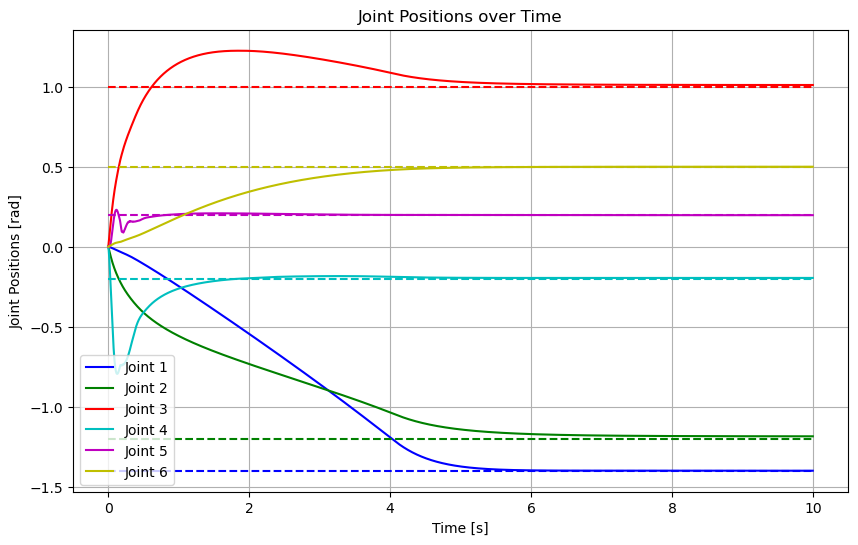

In [7]:
# Joint positions plot

colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], colors[i], label=f'Joint {i+1}')
    plt.hlines(q_des[i], 0, times[-1], colors[i], '--')  
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_positions_sliding.png')
plt.show()

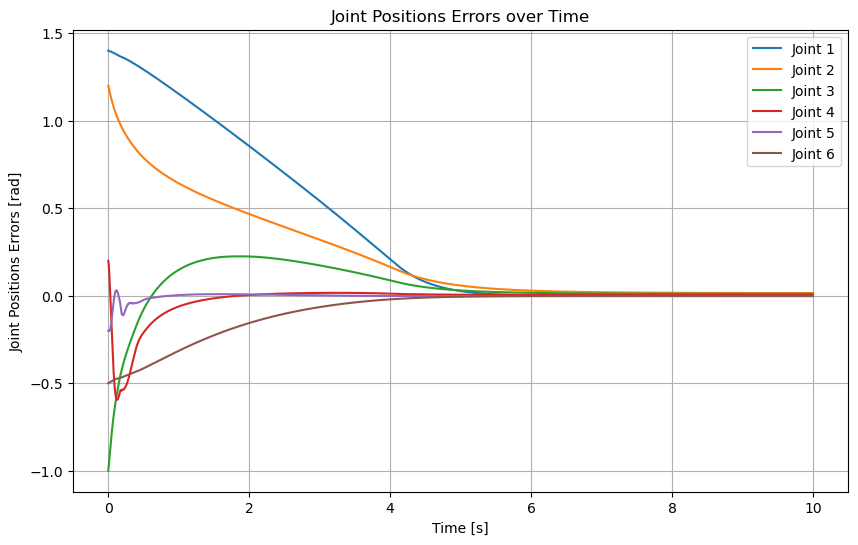

In [8]:
# Joint errors plot
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    pos_error = np.array([q_des[i] for j in range(positions.shape[0])])
    plt.plot(times, positions[:, i] - pos_error, label=f'Joint {i+1}') 
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions Errors [rad]')
plt.title('Joint Positions Errors over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_errors_sliding.png')
plt.show()

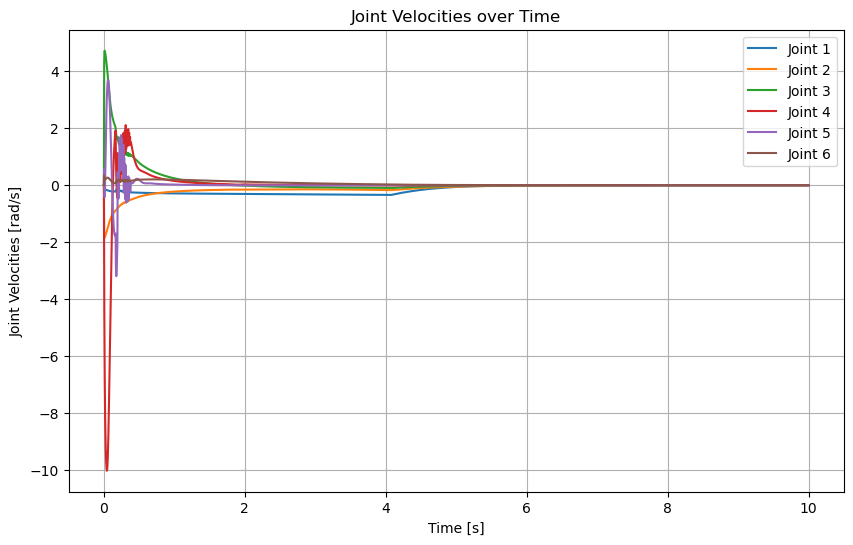

In [9]:
# Joint velocities plot
plt.figure(figsize=(10, 6))
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_velocities_sliding.png')
plt.show()

Как видно robust controller гораздо лучше справился с неопределенностями в системе и свел ошибку к минимуму, чтобы показать, что он действительно может справиться с неопределенностями в системе, а не настроен на конкретно заданную массу проведем симуляцию без доплнительной массы

### Weightless Simulation

In [5]:
# Create logging directories
Path("logs/videos").mkdir(parents=True, exist_ok=True)

# Initialize simulator
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=False,  # Using joint space control
    show_viewer=False,
    record_video=True,
    video_path="logs/videos/06_sliding_mode_weightless.mp4",
    fps=30,
    width=1920,
    height=1080
)

# Set joint damping (example values, adjust as needed)
damping = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm/rad/s
sim.set_joint_damping(damping)

# Set joint friction (example values, adjust as needed)
friction = np.array([1.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm
sim.set_joint_friction(friction)

# Get original properties
ee_name = "end_effector"

original_props = sim.get_body_properties(ee_name)
print(f"\nOriginal end-effector properties:")
print(f"Mass: {original_props['mass']:.3f} kg")
print(f"Inertia:\n{original_props['inertia']}")

# Add the end-effector mass and inertia
sim.modify_body_properties(ee_name, mass=0)
# Print modified properties
props = sim.get_body_properties(ee_name)
print(f"\nModified end-effector properties:")
print(f"Mass: {props['mass']:.3f} kg")
print(f"Inertia:\n{props['inertia']}")

# Set controller and run simulation
sim.set_controller(joint_controller_RB)
sim.run(time_limit=10.0)
# Process and save results
times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Original end-effector properties:
Mass: 0.010 kg
Inertia:
[0.0001 0.0001 0.0001]

Modified end-effector properties:
Mass: 0.000 kg
Inertia:
[0.0001 0.0001 0.0001]
Saving video to logs/videos/06_sliding_mode_weightless.mp4...


### Video

In [6]:
Video(os.path.join(current_dir, "logs/videos/06_sliding_mode_weightless.mp4"))

### Plots

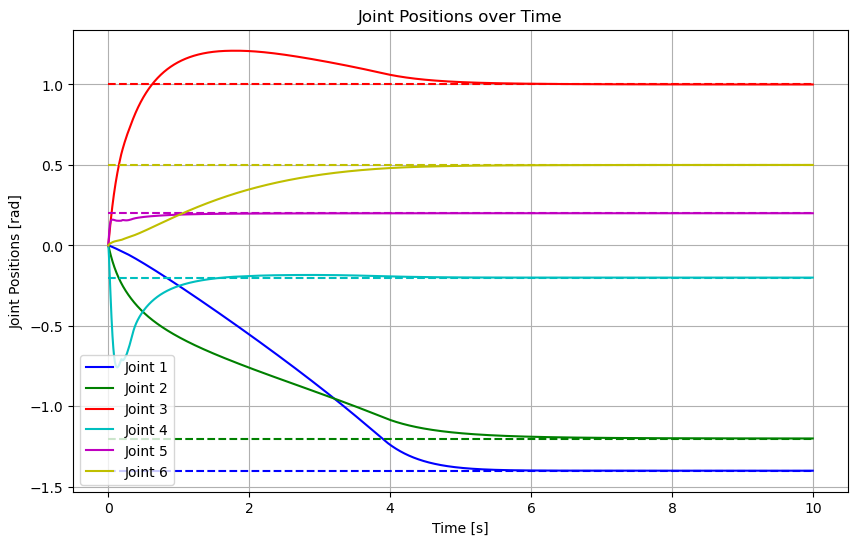

In [7]:
# Joint positions plot

colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], colors[i], label=f'Joint {i+1}')
    plt.hlines(q_des[i], 0, times[-1], colors[i], '--')  
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_positions_sliding_weightless.png')
plt.show()

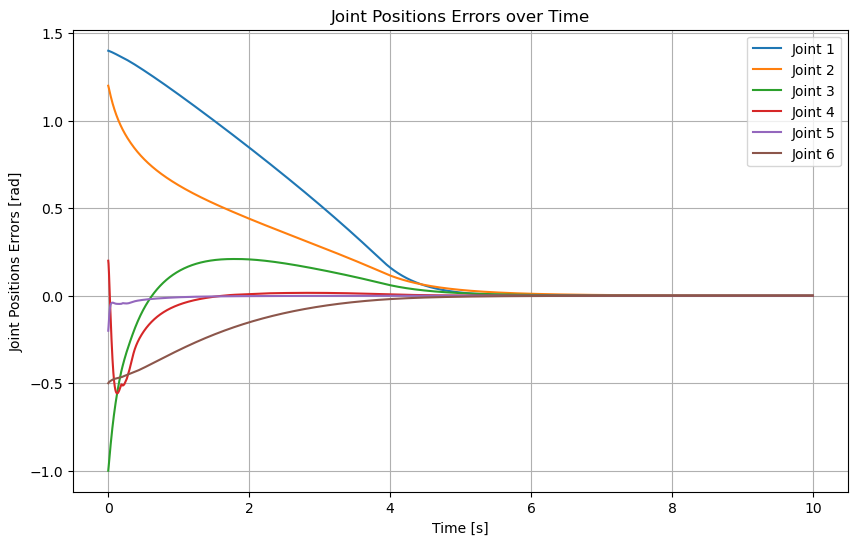

In [8]:
# Joint errors plot
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    pos_error = np.array([q_des[i] for j in range(positions.shape[0])])
    plt.plot(times, positions[:, i] - pos_error, label=f'Joint {i+1}') 
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions Errors [rad]')
plt.title('Joint Positions Errors over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_errors_sliding_weightless.png')
plt.show()

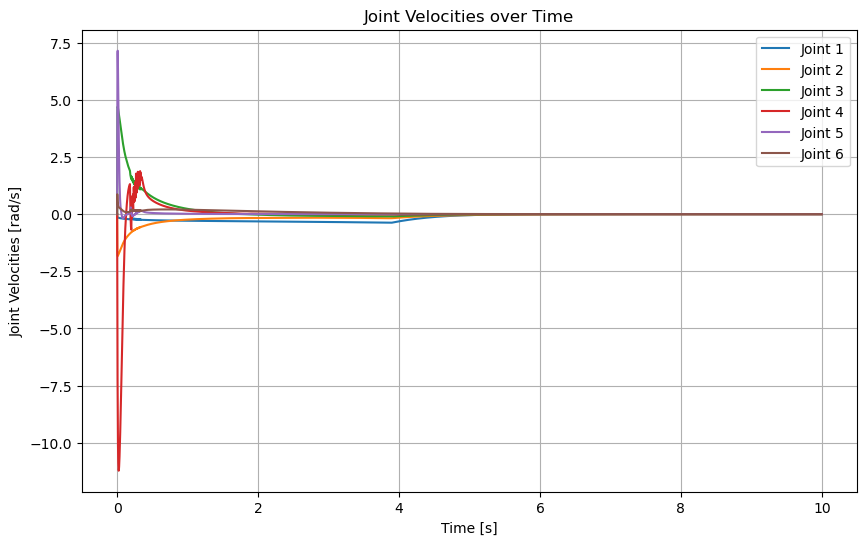

In [9]:
# Joint velocities plot
plt.figure(figsize=(10, 6))
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_velocities_sliding_weightless.png')
plt.show()

В результате подтвердилась работоспособность контроллера, как с добавочной массой, так и без нее, то есть спроектированный контроллер отрабатывает режим позиционирования в точке с хорошей точностью, чего не смог сделать inverse dynamics controller

### Unsmoothed controller

Ранее было была применена функция насыщения, в качестве $u_s$, однако дополнительно исследуем эффект, кторый возникает, если использовать функцию sign, теоретически мы увидим скачки, которые не позволят нам прийти в плоскоть $\mathbf{s} = 0$, а соответственно и дрбиться позиционирования в заданной точке.

In [5]:
def joint_controller_chat(q: np.ndarray, dq: np.ndarray, t: float) -> np.ndarray:
    """Joint space PD controller.
    
    Args:
        q: Current joint positions [rad]
        dq: Current joint velocities [rad/s]
        t: Current simulation time [s]
        
    Returns:
        tau: Joint torques command [Nm]
    """
    
    # Target joint configuration
    q0 = q_des
    dq0 = np.zeros(6)
    ddq0 = np.zeros(6)

    # Errors compute
    q_err = q0 - q
    dq_err = dq0 - dq
    
    # Dynamics computation
    pin.computeAllTerms(model, data, q, dq)
    M = data.M
    nle = data.nle

    # Control parameters
    L = np.diag([400, 400, 400, 100, 100, 1])
    k = 300
    p = 100 

    # Sliding surface
    s = dq_err + L @ q_err

    # Compute the control law
    u_hat = M @ (ddq0 + L@dq_err) + nle
    tau = u_hat + k * s / np.linalg.norm(s, ord=2)
    return tau

### Unsmoothed simulation

In [6]:
# Create logging directories
Path("logs/videos").mkdir(parents=True, exist_ok=True)

# Initialize simulator
sim = Simulator(
    xml_path="robots/universal_robots_ur5e/scene.xml",
    enable_task_space=False,  # Using joint space control
    show_viewer=False,
    record_video=True,
    video_path="logs/videos/06_sliding_mode_chattering.mp4",
    fps=30,
    width=1920,
    height=1080
)

# Set joint damping (example values, adjust as needed)
damping = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm/rad/s
sim.set_joint_damping(damping)

# Set joint friction (example values, adjust as needed)
friction = np.array([1.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Nm
sim.set_joint_friction(friction)

# Get original properties
ee_name = "end_effector"

original_props = sim.get_body_properties(ee_name)
print(f"\nOriginal end-effector properties:")
print(f"Mass: {original_props['mass']:.3f} kg")
print(f"Inertia:\n{original_props['inertia']}")

# Add the end-effector mass and inertia
sim.modify_body_properties(ee_name, mass=3)
# Print modified properties
props = sim.get_body_properties(ee_name)
print(f"\nModified end-effector properties:")
print(f"Mass: {props['mass']:.3f} kg")
print(f"Inertia:\n{props['inertia']}")

# Set controller and run simulation
sim.set_controller(joint_controller_chat)
sim.run(time_limit=10.0)
# Process and save results
times = np.array(sim.times)
positions = np.array(sim.positions)
velocities = np.array(sim.velocities)


Original end-effector properties:
Mass: 0.010 kg
Inertia:
[0.0001 0.0001 0.0001]

Modified end-effector properties:
Mass: 3.000 kg
Inertia:
[0.0001 0.0001 0.0001]
Saving video to logs/videos/06_sliding_mode_chattering.mp4...


### Video

In [7]:
Video(os.path.join(current_dir, "logs/videos/06_sliding_mode_chattering.mp4"))

### Plots

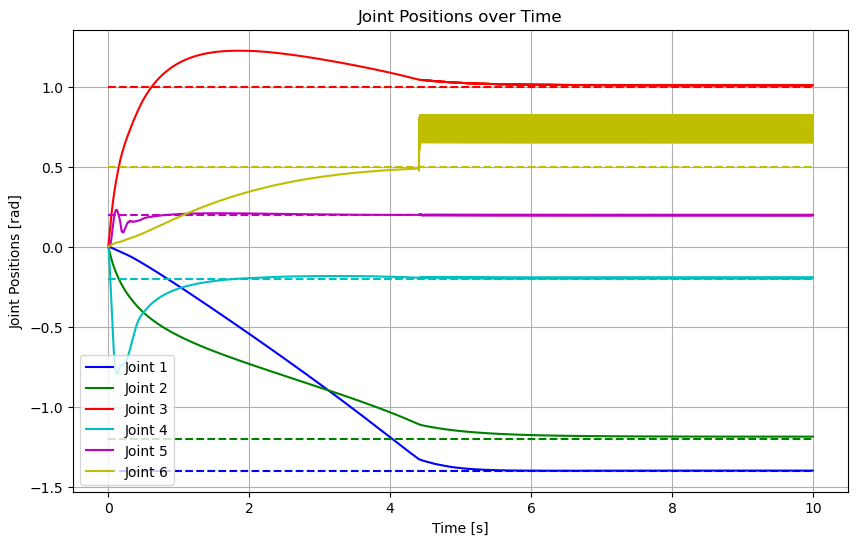

In [8]:
# Joint positions plot

colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    plt.plot(times, positions[:, i], colors[i], label=f'Joint {i+1}')
    plt.hlines(q_des[i], 0, times[-1], colors[i], '--')  
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions [rad]')
plt.title('Joint Positions over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_positions_sliding_chattering.png')
plt.show()

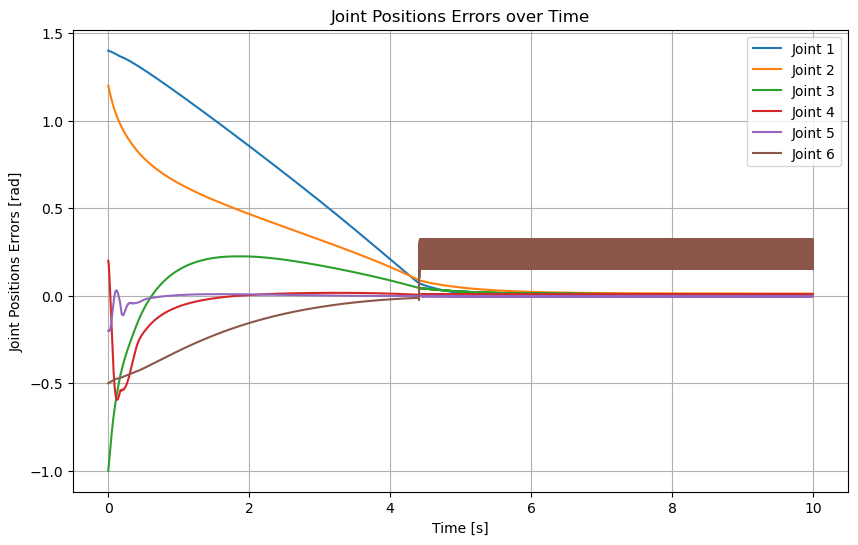

In [9]:
# Joint errors plot
plt.figure(figsize=(10, 6))
for i in range(positions.shape[1]):
    pos_error = np.array([q_des[i] for j in range(positions.shape[0])])
    plt.plot(times, positions[:, i] - pos_error, label=f'Joint {i+1}') 
plt.xlabel('Time [s]')
plt.ylabel('Joint Positions Errors [rad]')
plt.title('Joint Positions Errors over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_errors_sliding_chattering.png')
plt.show()

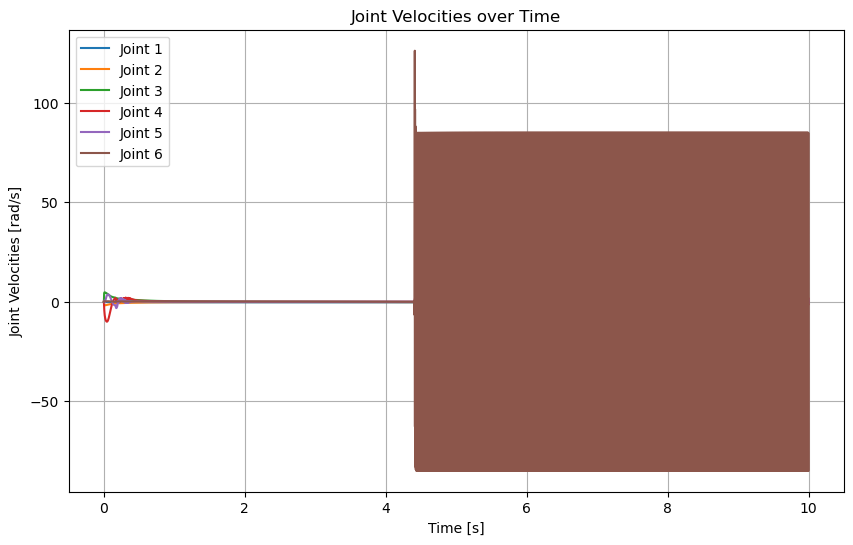

In [10]:
# Joint velocities plot
plt.figure(figsize=(10, 6))
for i in range(velocities.shape[1]):
    plt.plot(times, velocities[:, i], label=f'Joint {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Joint Velocities [rad/s]')
plt.title('Joint Velocities over Time')
plt.legend()
plt.grid(True)
plt.savefig('logs/plots/06_velocities_sliding_chattering.png')
plt.show()

Видно, что и на координатах и тем более на скоростях появились высокочастотные скачки. Это и связано с выбором функции sign, так как в 0 там происходит переброска из +1 в -1, при этом из-за присущей инерции системы, она не сразу перестает перестает двигаться, а продолжает некоторое время двигаться в противоположном направлении, после этого все в обратном направлении, этого явления мы и избежали, используя функцию saturation, так как в центральной области она имеет спуск к 0. При тестировании системы было выяснено, что скачки могут возникнкуть и при использовании функции saturation, так как эта зона "гладкого" спуска к 0, может быть недостаточно широкой, однако она снижает амплитуду этих скачков и, при увеличении ширины этой зоны, скачки полностью исчезают. Параметр, который регулирует ширину этой зоны, называется "saturation width" и обозначается в этой работе, как $\Phi$. В данной работе параметр $\Phi$ подобран так, чтобы полностбю избавиться от скачков.

## Conclusion

В данной работе был спроектирован контроллер, умеющий работать в условиях неопределенностей системы (как структурных, так и неструктурных), было показано, что такой контроллер может работать эффективно при различных значениях неопределенностей, также проверено, что с такой задачей не может справиться классический inverse dynamics controller. Интервал, в котором может работать контроллер, а так же его качество определяется его параметрами.

$k$ - определяет скорость схождения к скользящей поверхности

$\lambda$ - определяет скорость движения по скользящей поверхности

$\Phi$ - определяет ширину линейной зоны в функции насыщения и регулирует амплитуду скачков (т.е. точность, с которой мы достигнем желаемого положения)

Стоит заметить, что параметры настраиваются не независимо. В выражение для $\mathbf{s}$ входит $\lambda$, а с $\Phi$ сравнивается норма $\mathbf{s}$. $k$ умножается на $\mathbf{s}$, то есть необходимо выполнить многокритериальный поиск.

В данной работе параметры методом перебора были выбраны такими, чтобы удовлетворяли наложенным условиям, однако не утверждается, что это оптимальные значения, они являются рабочими (даже при изменении значений, имеющихся неопределенностей)